# Z Estimator

## Importing libraries

In [47]:
# Libraries to help with reading and manipulating data
import numpy as np
import gc
import pandas as pd
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import svm
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

## Define functions

In [2]:
# Define the function to create countplot with data labels above of each bar
# The parameters are: 
# 1- data: the dataframe
# 2- feature: the atrtribute of the DF to vidualise
# 3- figsize: size of the plot, by default height: 10 inches, width: 7 inches
# 4- order: sort out feature para: by default: None
# 5- hue: split the feature into different colors based on another category
def countplot_fn(data, feature, figsize = (10, 7), order = None, hue = None):
  total = len(data[feature]) # Declare variable for total
  plt.figure(figsize = figsize) # Create the plot with the paramter size
  # Verify if order exists
  if np.all(order):
    # Verify if hue exists
    if hue:
      ax = sns.countplot(data = data, x = feature, order = order, hue = hue); #The plot will take into account the order and the hue
    else:
      ax = sns.countplot(data = data, x = feature, order = order); #The plot will take into account the order only
  else:
    if hue:
      ax = sns.countplot(data = data, x = feature, hue = hue); #The plot will take into account the hue only
    else:
      ax = sns.countplot(data = data, x = feature); #The plot won't take into account the hue only nor rder
  plt.title(feature) # Adding title
  plt.xticks(rotation=90, fontsize=12) # Rotating X label
  # Print count on top of the bar
  for bar in ax.patches: 
    label = "{:.3f}%".format(100 * bar.get_height() / total)
    # ax.annotate(format(bar.get_height(), '.0f'), # Format the number
    ax.annotate(label, # Format the number
                (bar.get_x() + bar.get_width() / 2, bar.get_height()), # Locate the cursor to wirte the data label
                ha = 'center', va = 'center', #Horizontal and vertical alignment
                size = 10, xytext = (0, 8), textcoords='offset points' # Fontsize, starting point to write, type of coordinates
                )

In [3]:

# Define function to compute different metrics to check performance of a regression model
def model_performance_regression(model, predictors, target):
    """
    Function to compute different metrics to check regression model performance

    model: regressor
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    r2 = r2_score(target, pred)  # to compute R-squared
    # adjr2 = adj_r2_score(predictors, target, pred)  # to compute adjusted R-squared
    rmse = np.sqrt(mean_squared_error(target, pred))  # to compute RMSE
    mae = mean_absolute_error(target, pred)  # to compute MAE
    # mape = mape_score(target, pred)  # to compute MAPE

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "RMSE": rmse,
            "MAE": mae,
            "R-squared": r2,
            # "Adj. R-squared": adjr2,
            # "MAPE": mape,
        },
        index=[0],
    )

    return df_perf

## Extracting the dataset

In [4]:
df_train_prop2016 = pd.read_csv('properties_2016.csv')
df_train_prop2017 = pd.read_csv('properties_2017.csv')
df_train_prop = pd.concat([df_train_prop2016, df_train_prop2017])
df_train_prop.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,10754147,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,9.0,2015.0,9.0,NaN,NaN,NaN,NaN
1,10759547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN
2,10843547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,650756.0,1413387.0,2015.0,762631.0,20800.37,NaN,NaN,NaN
3,10859147,NaN,NaN,NaN,0.0,0.0,3.0,7.0,NaN,NaN,...,1.0,NaN,571346.0,1156834.0,2015.0,585488.0,14557.57,NaN,NaN,NaN
4,10879947,NaN,NaN,NaN,0.0,0.0,4.0,NaN,NaN,NaN,...,NaN,NaN,193796.0,433491.0,2015.0,239695.0,5725.17,NaN,NaN,NaN


In [5]:
print(r'The dataset has {rownum} rows and {colnum} columns'.format(rownum = df_train_prop.shape[0], colnum = df_train_prop.shape[1]))

The dataset has 5970434 rows and 58 columns


In [6]:
df_train_2016 = pd.read_csv('train_2016_v2.csv')
df_train_2017 = pd.read_csv('train_2017.csv')
df_train = pd.concat([df_train_2016, df_train_2017])
df_train.head()

,parcelid,logerror,transactiondate
0,11016594,0.0276,2016-01-01
1,14366692,-0.1684,2016-01-01
2,12098116,-0.0040,2016-01-01
3,12643413,0.0218,2016-01-02
4,14432541,-0.0050,2016-01-02


In [7]:
print(r'The dataset has {rownum} rows and {colnum} columns'.format(rownum = df_train_2016.shape[0], colnum = df_train_2017.shape[1]))

The dataset has 90275 rows and 3 columns


In [8]:
df = pd.merge(df_train_prop,   df_train,  on="parcelid", how="inner")

In [9]:
print(r'The dataset has {rownum} rows and {colnum} columns'.format(rownum = df_train.shape[0], colnum = df_train.shape[1]))

The dataset has 167888 rows and 3 columns


In [10]:
# Delete the old DataFrames
del [df_train_prop, df_train, df_train_2016, df_train_2017, df_train_prop2016, df_train_prop2017]
 
# Perform garbage collection
gc.collect()

20

## Data preprocessing

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 335776 entries, 0 to 335775
Data columns (total 60 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   parcelid                      335776 non-null  int64  
 1   airconditioningtypeid         107623 non-null  float64
 2   architecturalstyletypeid      936 non-null     float64
 3   basementsqft                  186 non-null     float64
 4   bathroomcnt                   335601 non-null  float64
 5   bedroomcnt                    335601 non-null  float64
 6   buildingclasstypeid           63 non-null      float64
 7   buildingqualitytypeid         214377 non-null  float64
 8   calculatedbathnbr             332216 non-null  float64
 9   decktypeid                    2548 non-null    float64
 10  finishedfloor1squarefeet      25851 non-null   float64
 11  calculatedfinishedsquarefeet  334084 non-null  float64
 12  finishedsquarefeet12          319156 non-nul

In [12]:
df.isnull().sum() / df.shape[0] * 100.00

parcelid                         0.000000
airconditioningtypeid           67.947977
architecturalstyletypeid        99.721243
basementsqft                    99.944606
bathroomcnt                      0.052118
bedroomcnt                       0.052118
buildingclasstypeid             99.981237
buildingqualitytypeid           36.154758
calculatedbathnbr                1.060231
decktypeid                      99.241161
finishedfloor1squarefeet        92.301117
calculatedfinishedsquarefeet     0.503907
finishedsquarefeet12             4.949728
finishedsquarefeet13            99.955327
finishedsquarefeet15            96.076551
finishedsquarefeet50            92.301117
finishedsquarefeet6             99.522301
fips                             0.052118
fireplacecnt                    89.333365
fullbathcnt                      1.060231
garagecarcnt                    66.944630
garagetotalsqft                 66.944630
hashottuborspa                  97.682681
heatingorsystemtypeid           37

There a huge percentage of missing values in the columns

In [13]:
# Filling the missing values with a new id (Unknown) based on the data dictionary
df = df.fillna({'airconditioningtypeid': 14,
                'architecturalstyletypeid': 28,
                'buildingclasstypeid': 6,
                'heatingorsystemtypeid' : 26,
                'storytypeid' : 36,
                'typeconstructiontypeid' : 19
                })

- The following columns don't give any useful information, so they may be deleted. 

In [14]:
df.drop(['decktypeid', 'calculatedbathnbr', 'fips', 'regionidcity', 'regionidcounty', 'regionidneighborhood', 'regionidzip', 'propertyzoningdesc',
         'basementsqft', 'finishedfloor1squarefeet', 
         'rawcensustractandblock', 'propertycountylandusecode', 'censustractandblock', 'parcelid'], axis=1, inplace=True)

In [15]:
df.drop_duplicates(inplace=True)

In [16]:
# Enconding booleans as 1 or 0
booleanColumns = ['hashottuborspa', 'fireplaceflag', 'taxdelinquencyflag']
for column in booleanColumns:
    df[column] = df[column].apply(lambda x: 1 if x == True or x == 'Y' else 0)

In [17]:
# Checking the years of deliquency depending on the flag
df.groupby(['taxdelinquencyyear', 'taxdelinquencyflag']).size()

taxdelinquencyyear  taxdelinquencyflag
3.0                 1                        2
4.0                 1                        2
6.0                 1                        8
7.0                 1                       36
8.0                 1                       76
9.0                 1                      221
10.0                1                      310
11.0                1                      366
12.0                1                      534
13.0                1                      794
14.0                1                     2858
15.0                1                     4155
99.0                1                        4
dtype: int64

- It shows only years when the flag is 1, it can be filled the missing ones with 0

In [18]:
# Filling with 0
df = df.fillna({'taxdelinquencyyear': 0})

- Converting the columns id from float to integer, to reduce the training time later

In [19]:
df = df.astype({'airconditioningtypeid': int,
                'architecturalstyletypeid': int,
                'buildingclasstypeid': int,
                'heatingorsystemtypeid' : int,
                'storytypeid' : int,
                'typeconstructiontypeid' : int,
                'hashottuborspa' : int, 
                'fireplaceflag' : int, 
                'taxdelinquencyflag' : int
                # 'assessmentyear' : int
                })

In [20]:
df["transactiondate"] = pd.to_datetime(df["transactiondate"], format="%Y-%m-%d")

In [21]:
# Filling the missing values with the median, to make the model robust
df.fillna(df.median(), inplace=True)

In [22]:
df['latitude'] = df['latitude'] / 1e6

In [23]:
df['longitude'] = df['longitude'] / 1e6

## Exploratory Data Analysis

In [24]:
# Check the correlation coefficient among the other columns
corr_cols = [col for col in df.columns if col not in ['logerror', 'transactiondate', 'airconditioningtypeid', 'architecturalstyletypeid', 'buildingclasstypeid', 
                                                   'heatingorsystemtypeid', 'storytypeid', 'typeconstructiontypeid', 'hashottuborspa', 'fireplaceflag', 'taxdelinquencyflag']
                                        if df[col].dtype=='float64']
print(corr_cols)

['bathroomcnt', 'bedroomcnt', 'buildingqualitytypeid', 'calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'finishedsquarefeet13', 'finishedsquarefeet15', 'finishedsquarefeet50', 'finishedsquarefeet6', 'fireplacecnt', 'fullbathcnt', 'garagecarcnt', 'garagetotalsqft', 'latitude', 'longitude', 'lotsizesquarefeet', 'poolcnt', 'poolsizesum', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7', 'propertylandusetypeid', 'roomcnt', 'threequarterbathnbr', 'unitcnt', 'yardbuildingsqft17', 'yardbuildingsqft26', 'yearbuilt', 'numberofstories', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'assessmentyear', 'landtaxvaluedollarcnt', 'taxamount', 'taxdelinquencyyear']


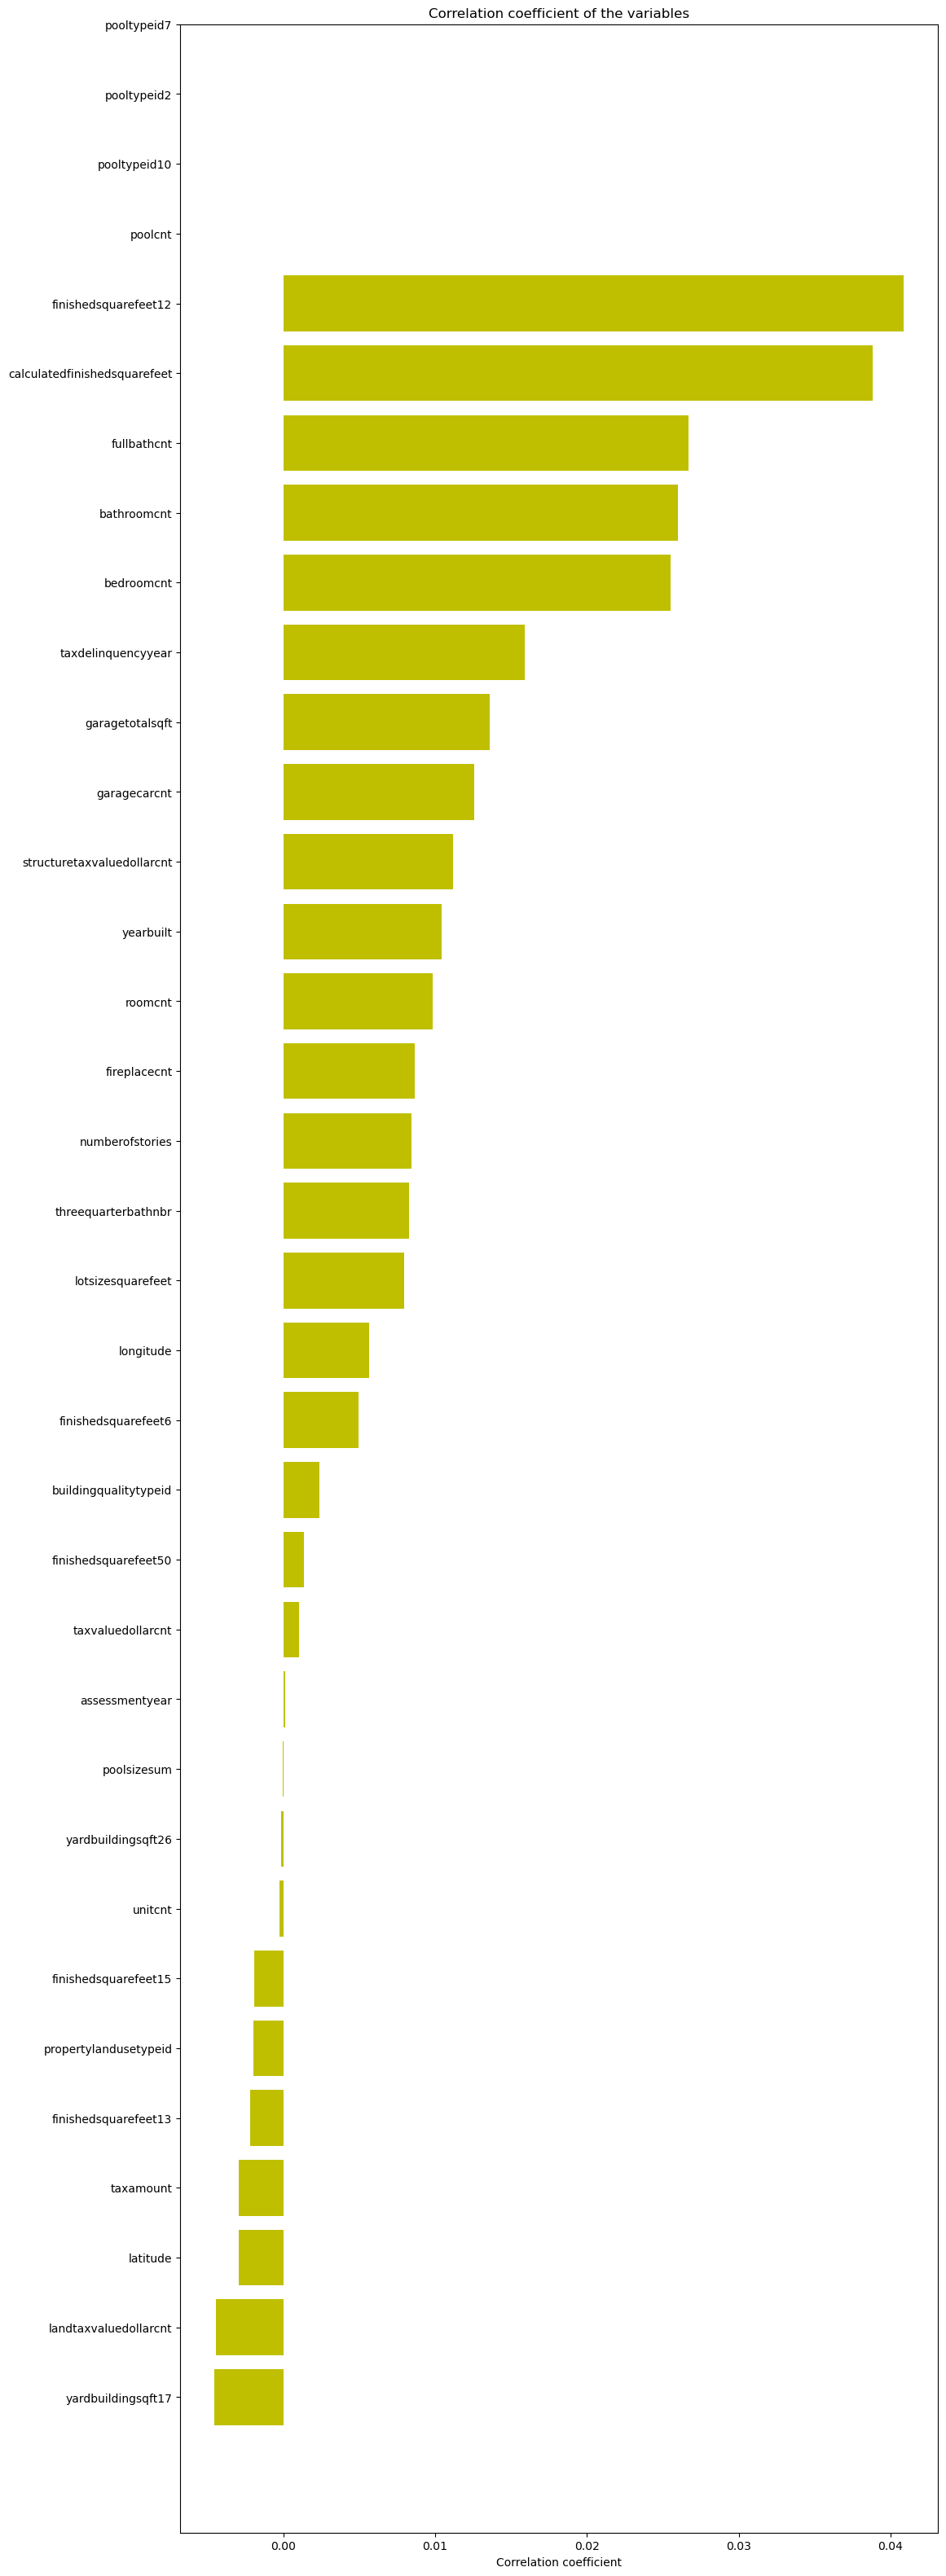

In [25]:
labels = []
values = []
for col in corr_cols:
    labels.append(col)
    values.append(np.corrcoef(df[col].values, df.logerror.values)[0,1])
corr_df = pd.DataFrame({'col_labels':labels, 'corr_values':values})
corr_df = corr_df.sort_values(by='corr_values')
    
ind = np.arange(len(labels))
width = 0.9
fig, ax = plt.subplots(figsize=(12,40))
rects = ax.barh(ind, np.array(corr_df.corr_values.values), color='y')
ax.set_yticks(ind)
ax.set_yticklabels(corr_df.col_labels.values, rotation='horizontal')
ax.set_xlabel("Correlation coefficient")
ax.set_title("Correlation coefficient of the variables")
#autolabel(rects)
plt.show();

- Nevertheless, the correlation is to low, even some columns are null. These columns will be removed from the dataset: poolcnt, pooltypeid10, pooltypeid2, pooltypeid7; they won't help to the model

In [26]:
df.drop(['poolcnt', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7'], axis=1, inplace=True)

In [27]:
corr_cols.remove('poolcnt')
corr_cols.remove('pooltypeid10')
corr_cols.remove('pooltypeid2')
corr_cols.remove('pooltypeid7')

bathroomcnt


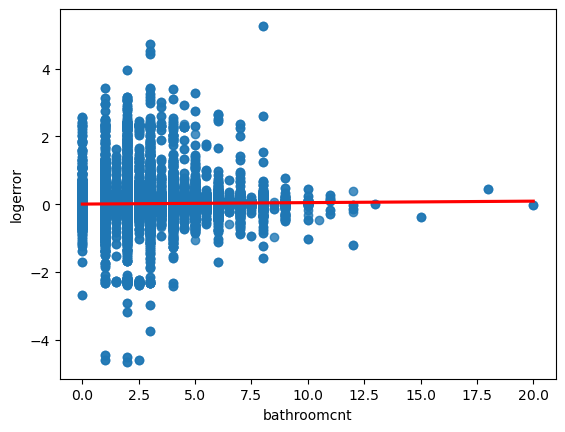

bedroomcnt


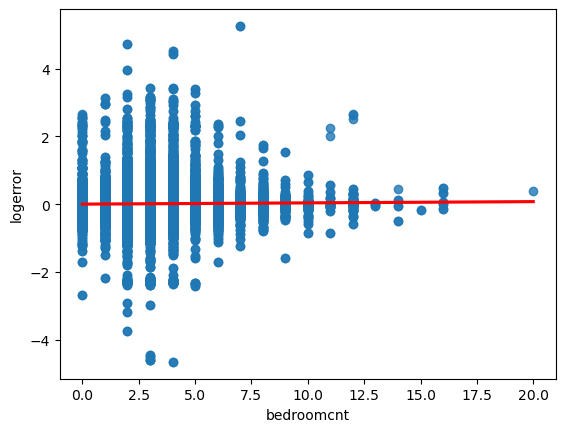

buildingqualitytypeid


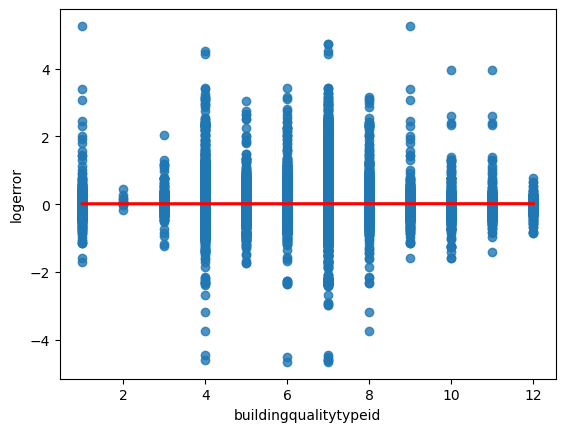

calculatedfinishedsquarefeet


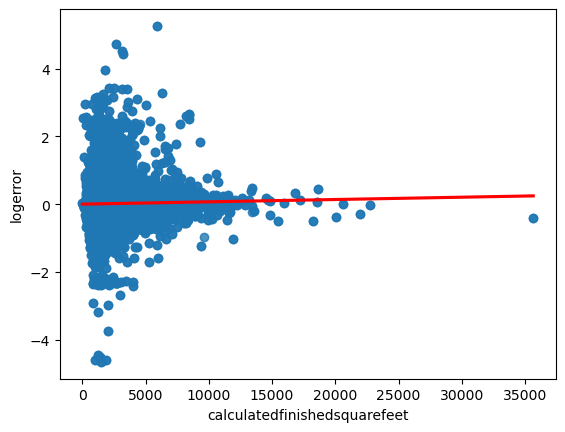

finishedsquarefeet12


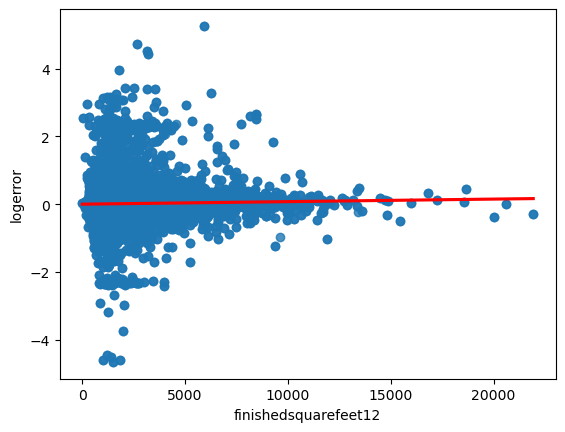

finishedsquarefeet13


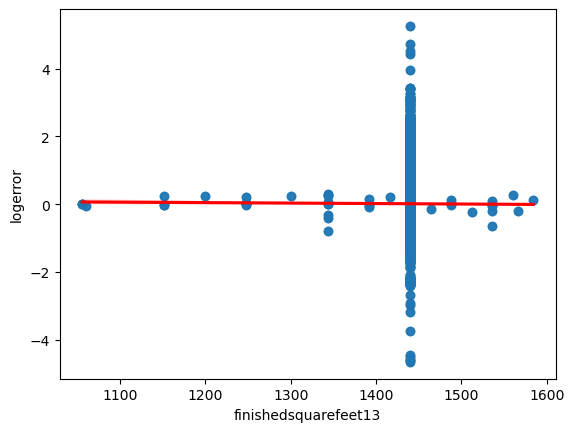

finishedsquarefeet15


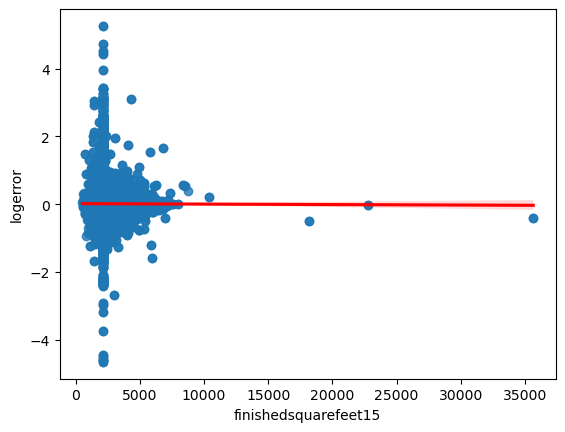

finishedsquarefeet50


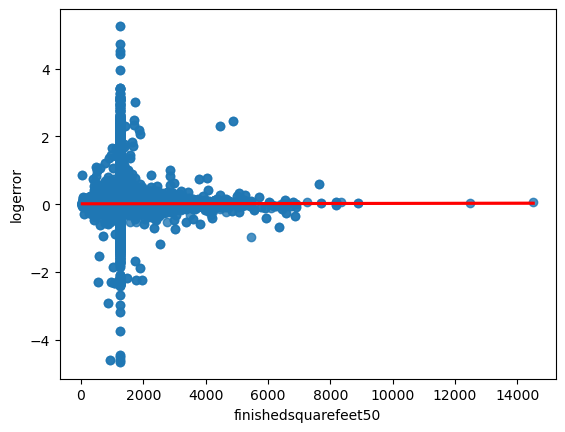

finishedsquarefeet6


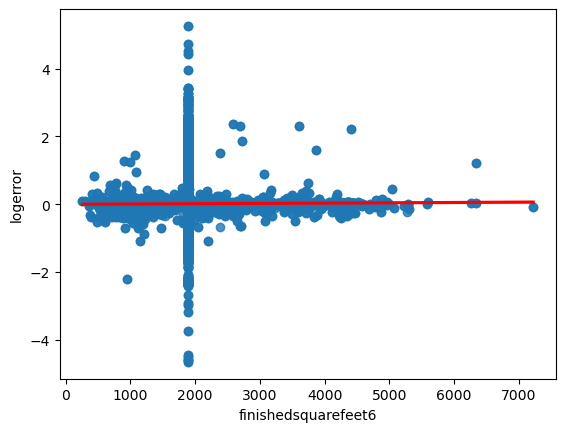

fireplacecnt


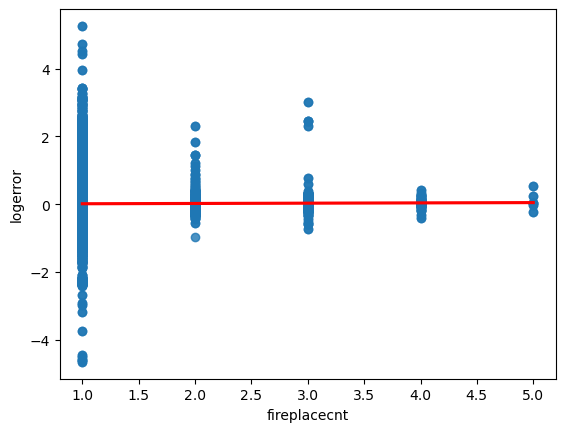

fullbathcnt


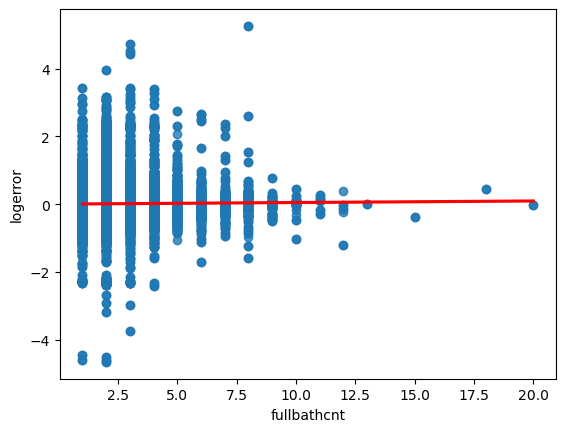

garagecarcnt


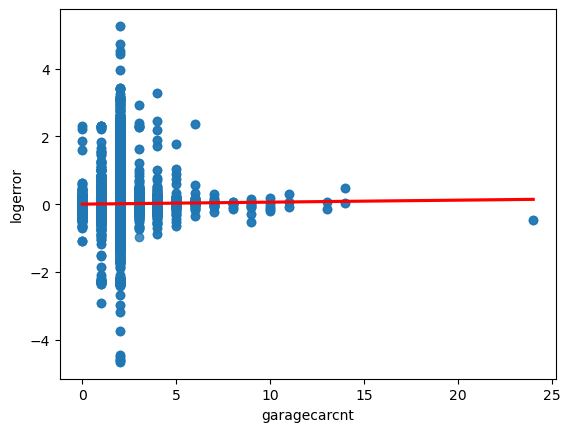

garagetotalsqft


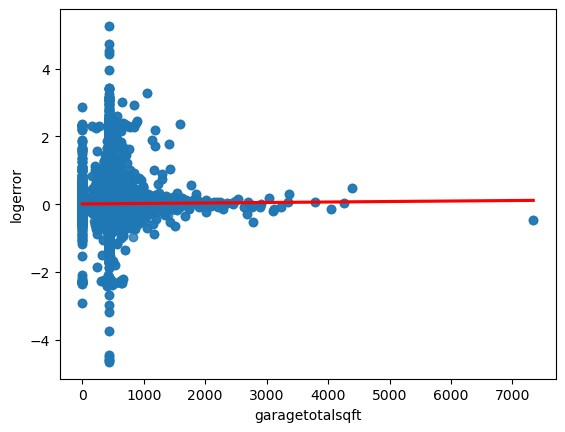

latitude


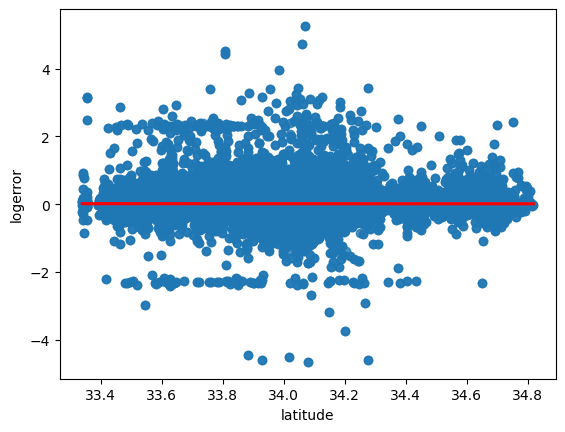

longitude


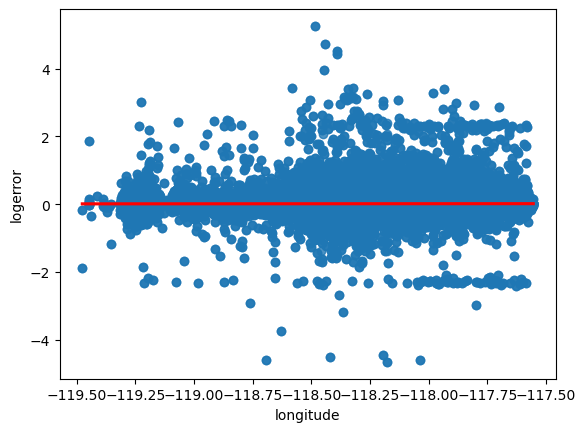

lotsizesquarefeet


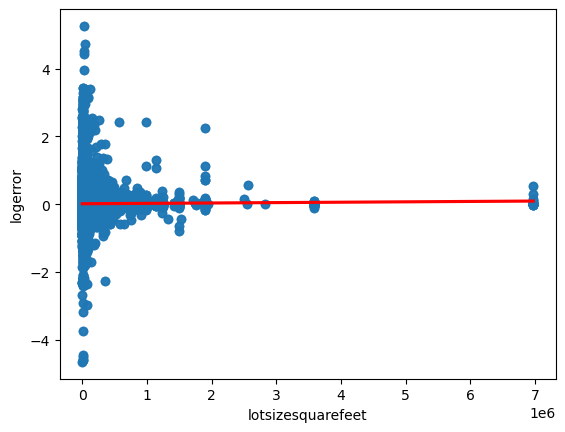

poolsizesum


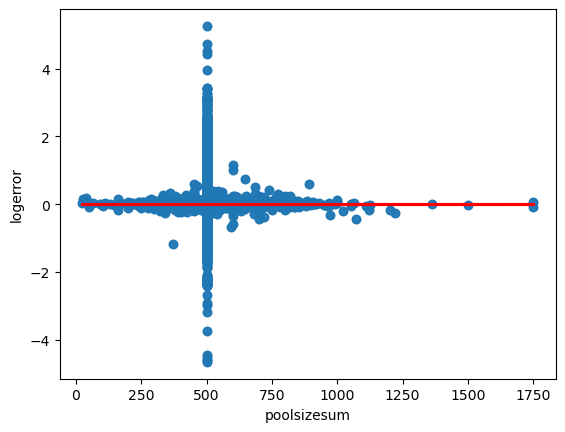

propertylandusetypeid


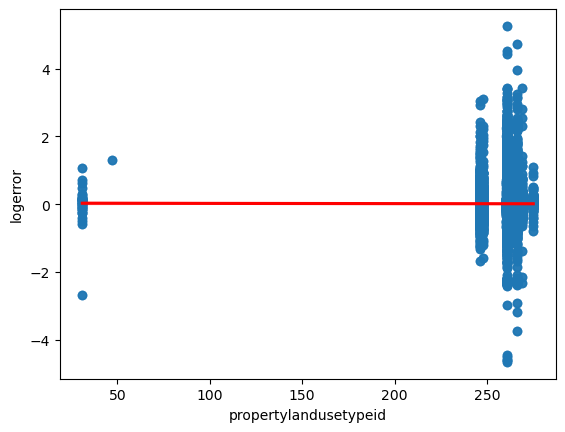

roomcnt


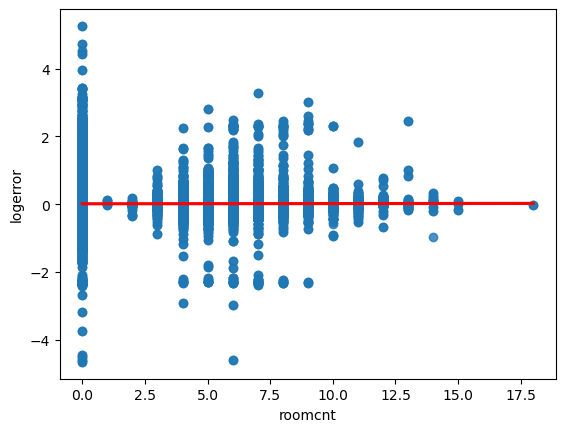

threequarterbathnbr


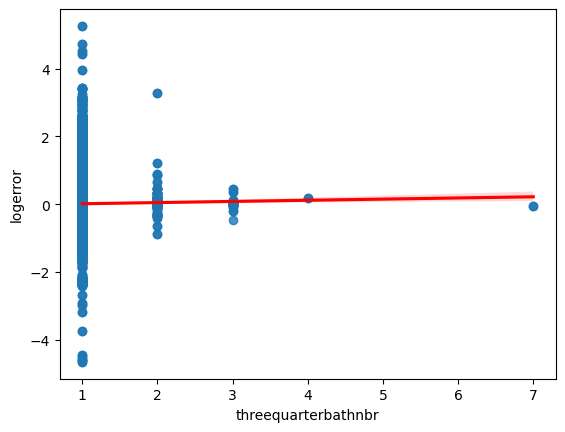

unitcnt


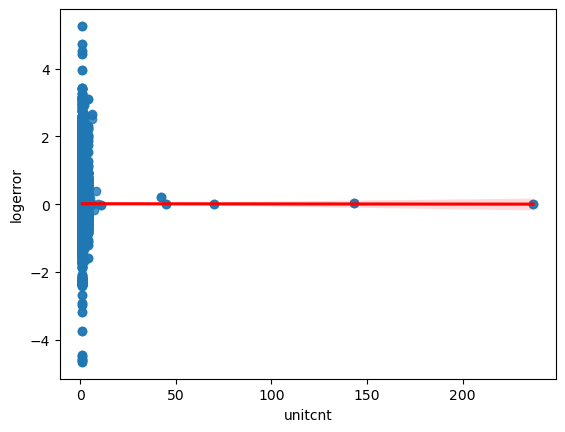

yardbuildingsqft17


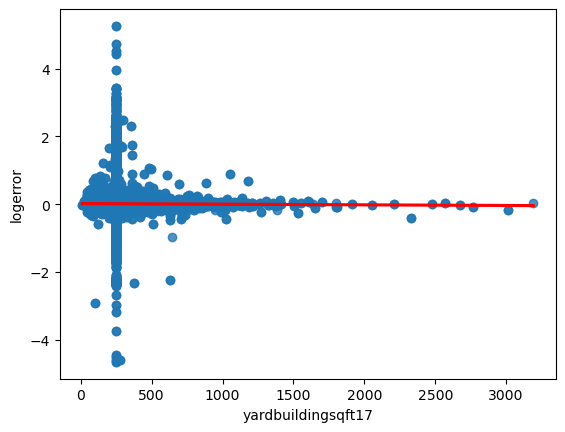

yardbuildingsqft26


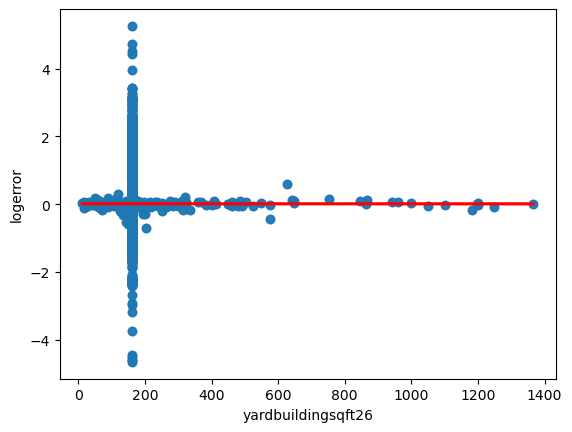

yearbuilt


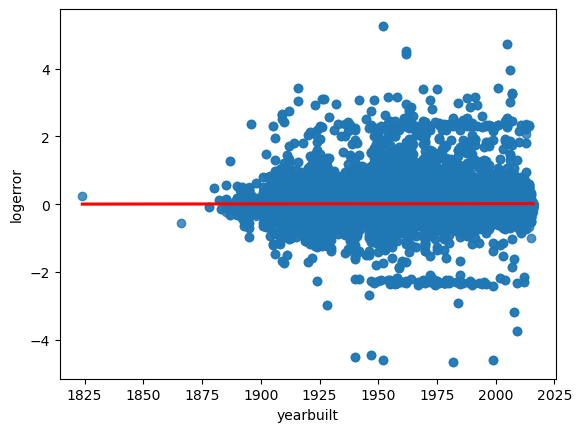

numberofstories


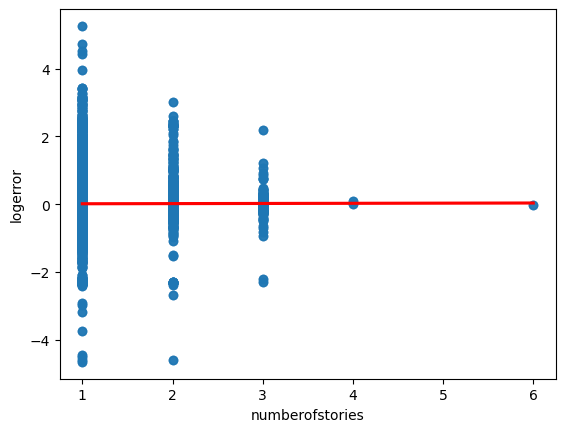

structuretaxvaluedollarcnt


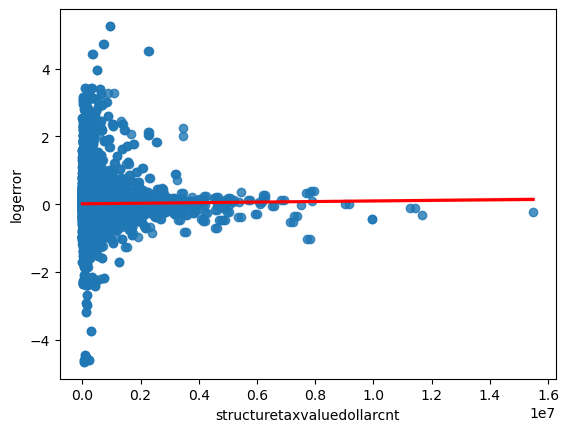

taxvaluedollarcnt


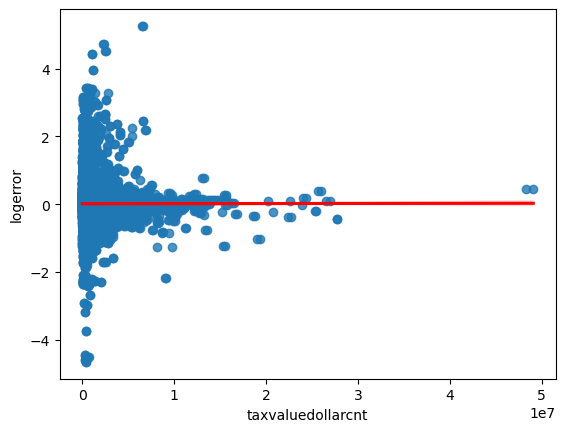

assessmentyear


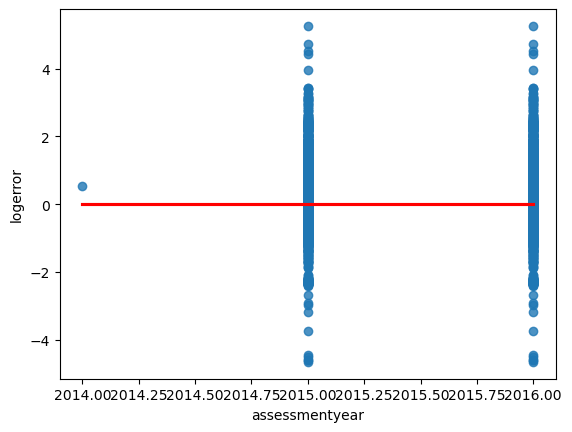

landtaxvaluedollarcnt


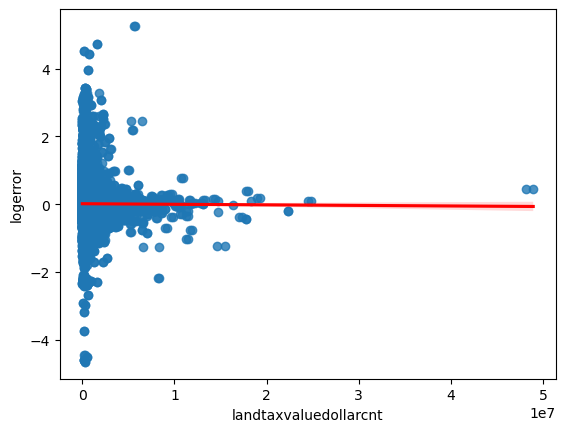

taxamount


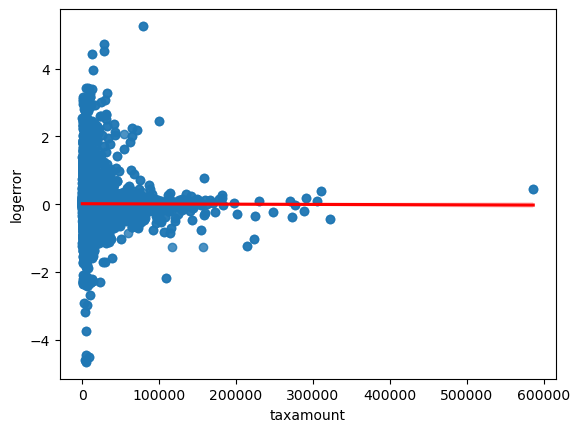

taxdelinquencyyear


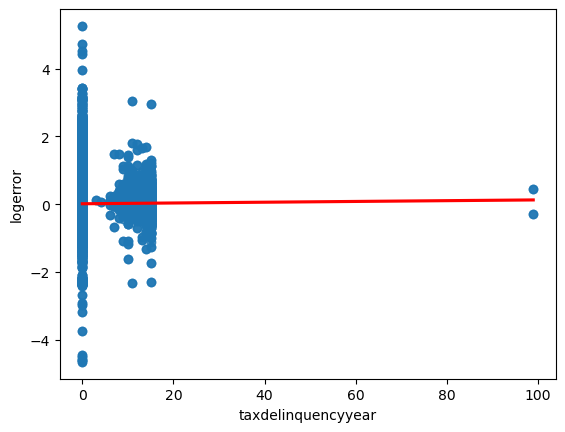

In [28]:
for column in corr_cols:
    print(column)
    sns.regplot(data=df, x=column, y="logerror", line_kws=dict(color="r"))
    plt.show();

There are some outliers, they won't be fixed because those values are possible

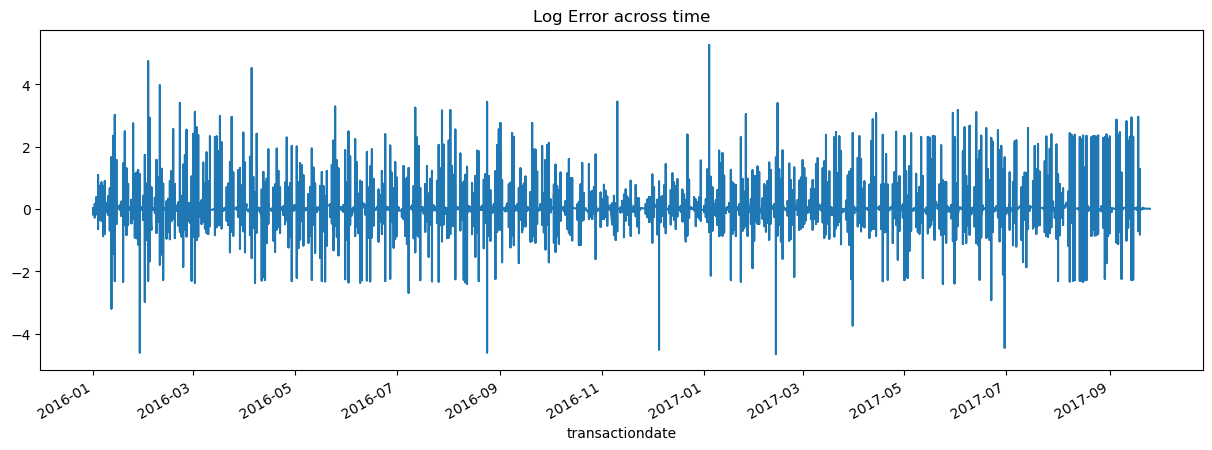

In [29]:
df.plot(x='transactiondate', y='logerror', kind='line', legend=None, 
        title='Log Error across time', xlabel='transactiondate', fontsize=10, figsize=(15,5));

Some dates have huge variation of log error

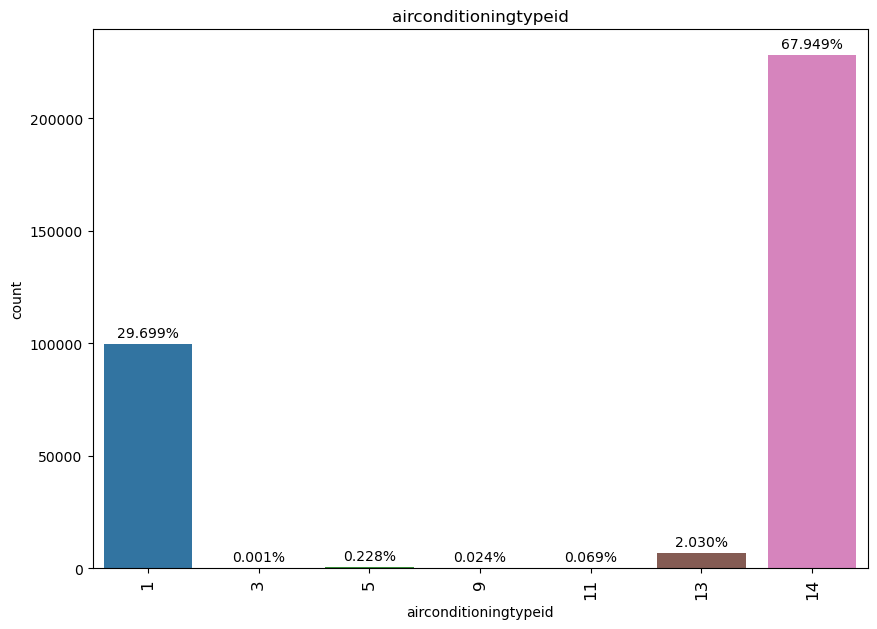

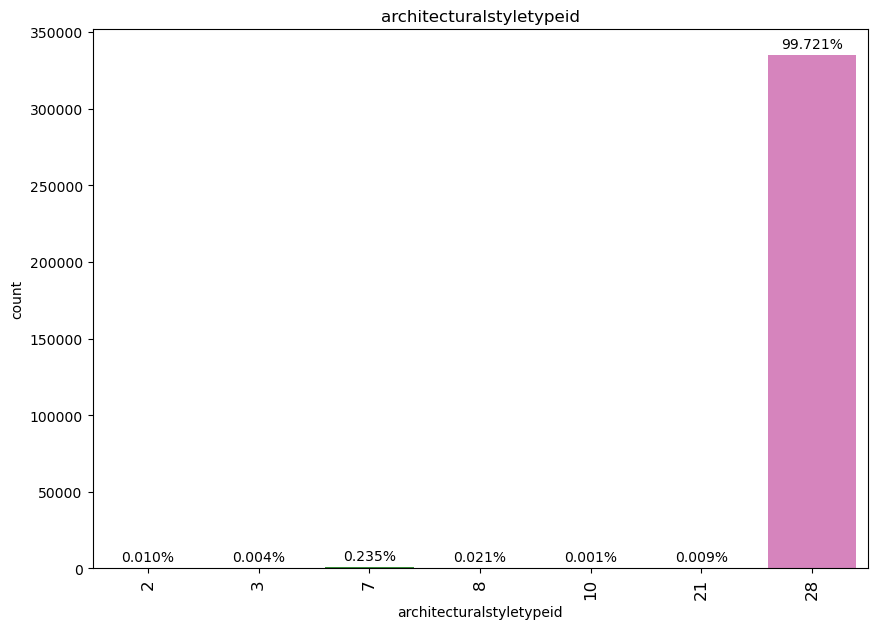

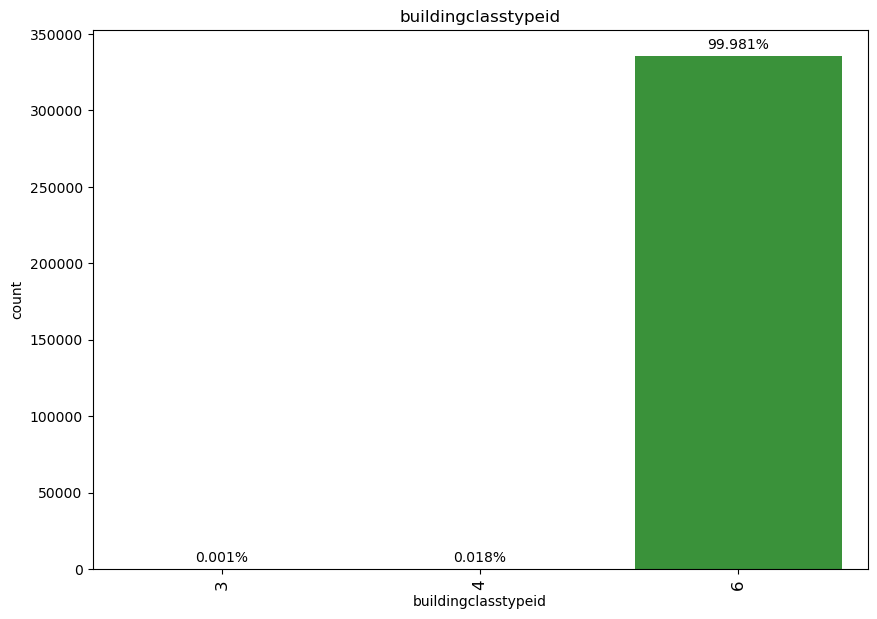

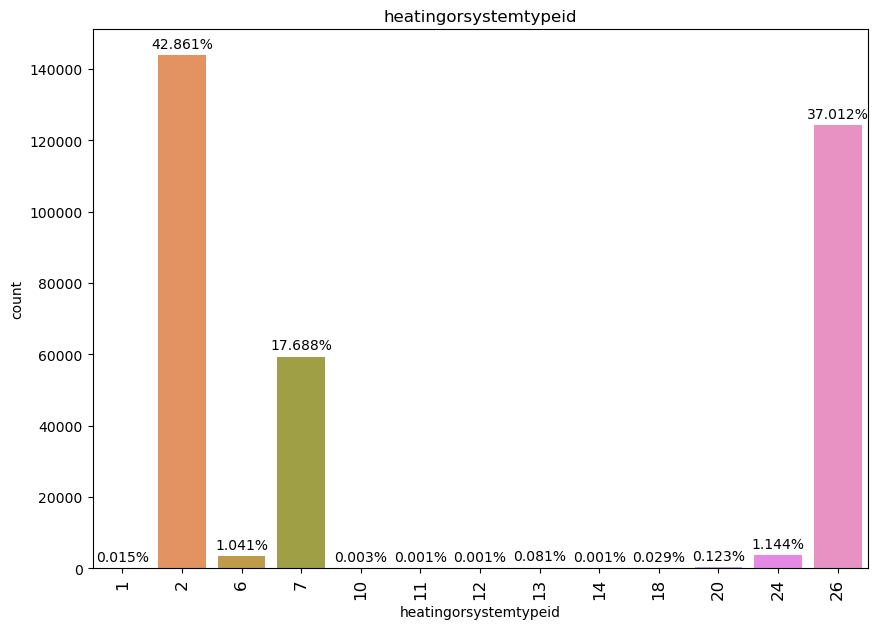

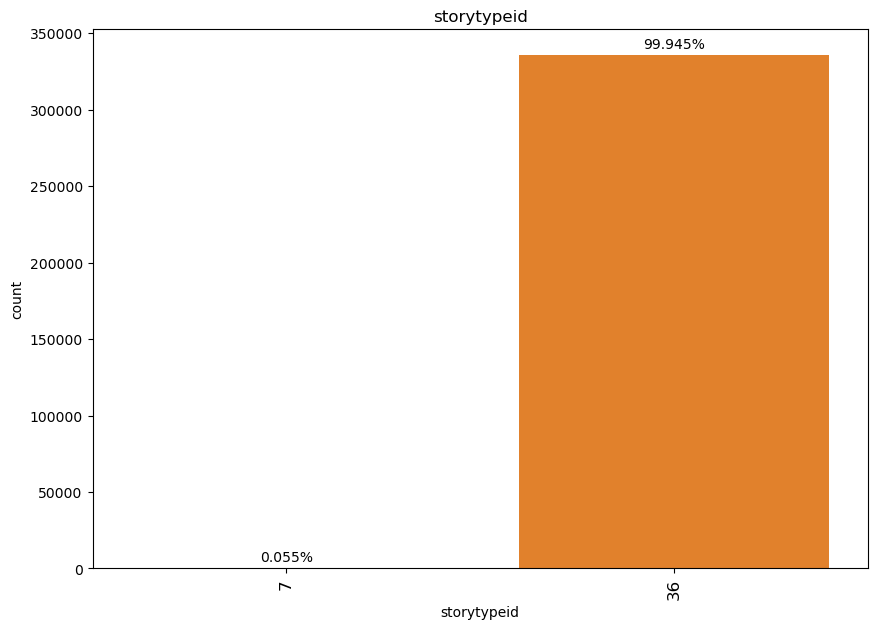

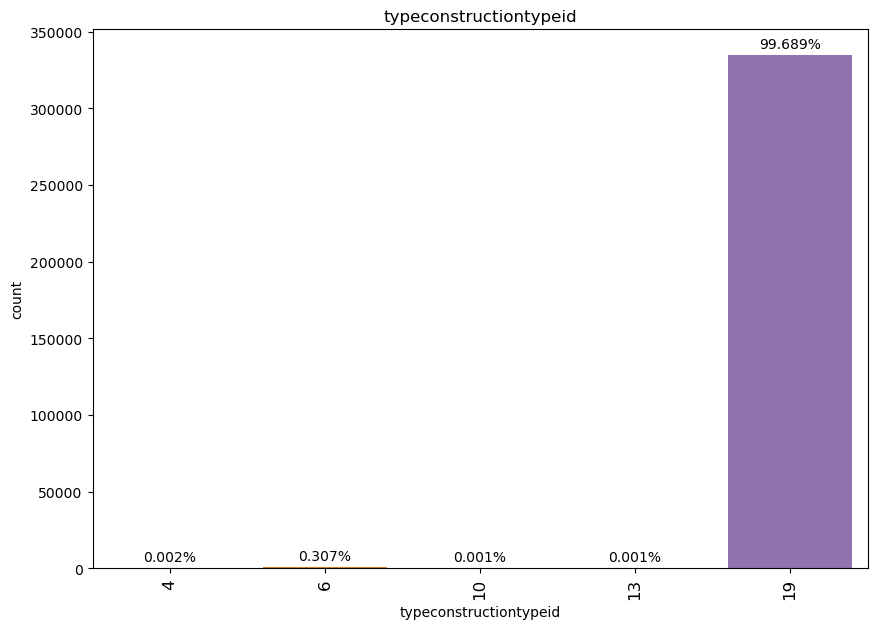

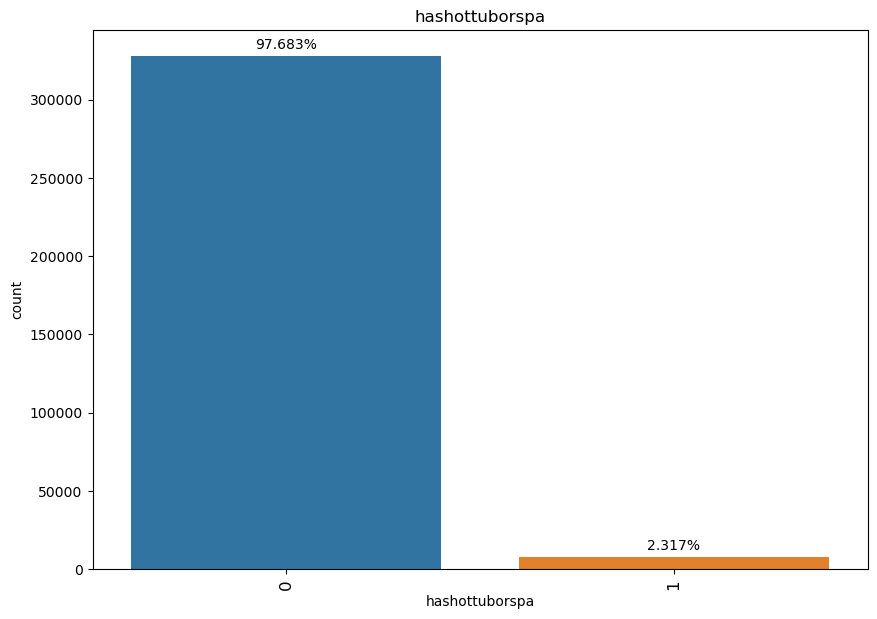

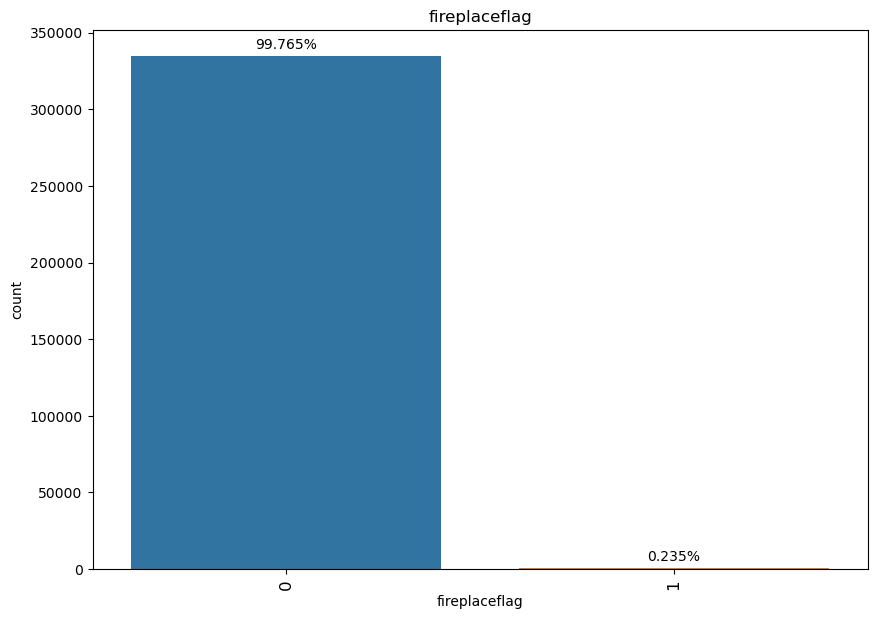

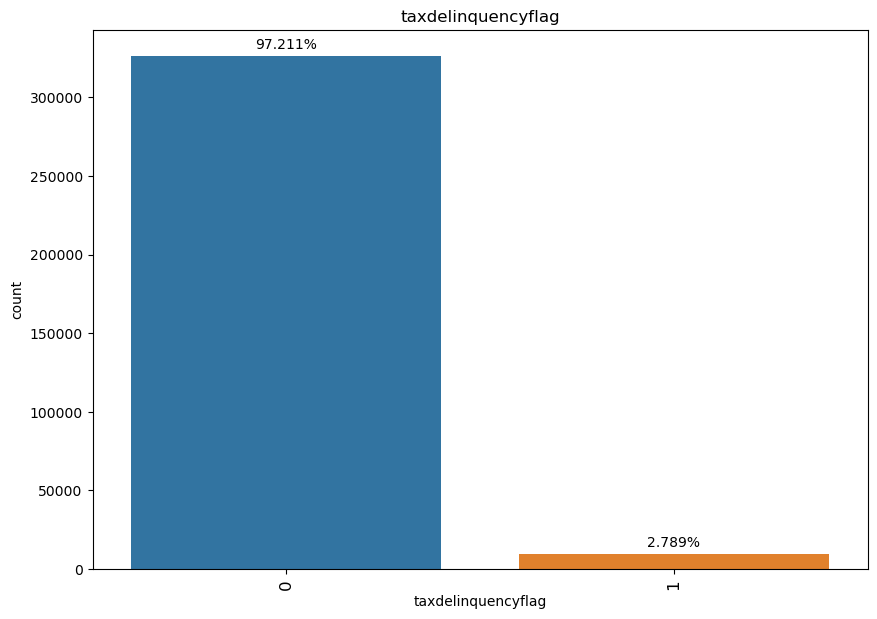

In [30]:
obj_col = ['airconditioningtypeid', 'architecturalstyletypeid', 'buildingclasstypeid', 
           'heatingorsystemtypeid', 'storytypeid', 'typeconstructiontypeid', 'hashottuborspa', 'fireplaceflag', 'taxdelinquencyflag']

for column in obj_col:
    countplot_fn(data = df, feature = column);

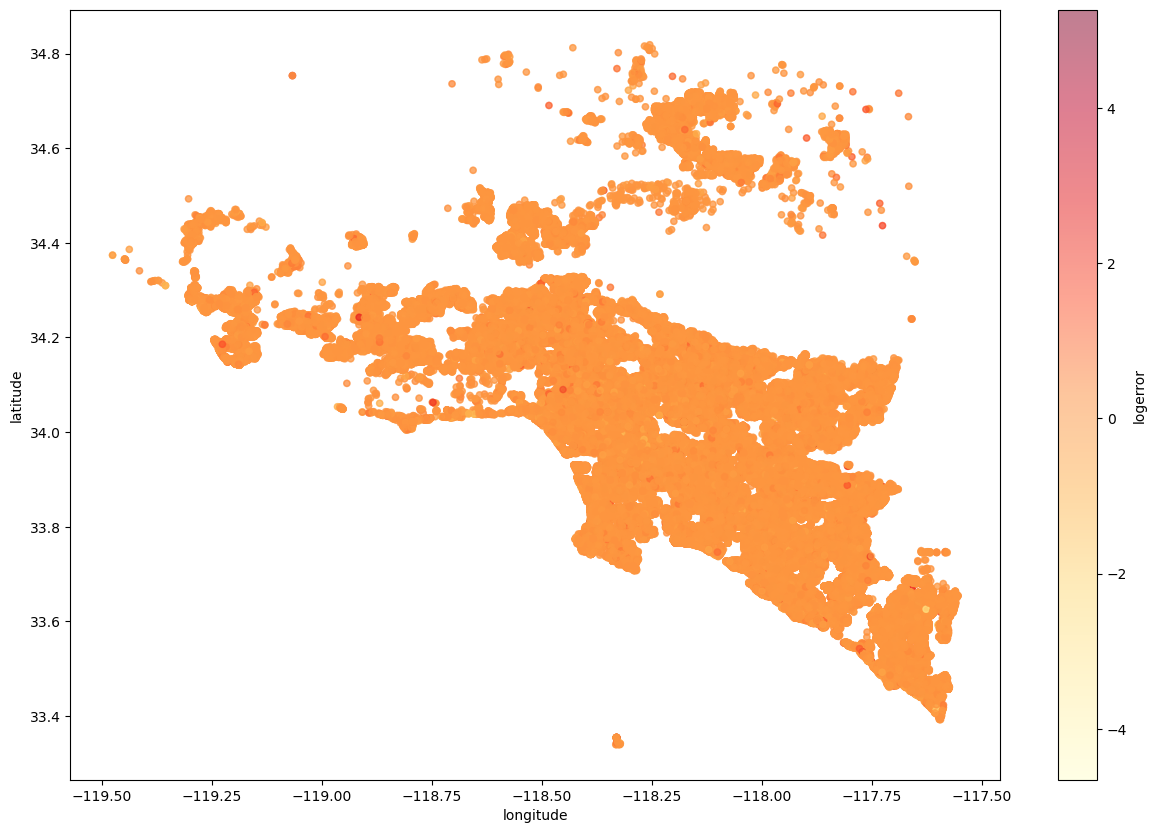

In [31]:
df.plot(x="longitude", y="latitude", kind="scatter", c="logerror", colormap="YlOrRd", figsize=(15, 10), alpha= 0.5);

Looking the lat and log, the places with large variation are not located in a specific region

In [32]:
df['transactionyear'] = df['transactiondate'].dt.year
df['transactionmonth'] = df['transactiondate'].dt.month
df['transactionday'] = df['transactiondate'].dt.day

In [33]:
df.drop(['transactiondate'], axis=1, inplace=True)

## Model Building

### Splitting sample

In [34]:
# Separating independetn and depndent variable
X = df.drop(["logerror"], axis=1)
y = df["logerror"]

In [35]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)

In [36]:
print(f'Number of rows in train data (70%) = {x_train.shape[0]}')
print(f'Number of rows in test data (30%) = {x_test.shape[0]}')

Number of rows in train data (70%) = 235037
Number of rows in test data (30%) = 100731


### Creating Linear Model

In [37]:
lin_reg_model = LinearRegression()
lin_reg_model.fit(x_train, y_train)

LinearRegression()

In [38]:
# Checking model performance on train set
print("Training Performance\n")
lin_reg_model_train_perf = model_performance_regression(lin_reg_model, x_train, y_train)
lin_reg_model_train_perf

Training Performance



,RMSE,MAE,R-squared
0,0.16759,0.069777,0.004987


The metrics are poor. Checking the coefficients.

In [39]:
coef_df = pd.DataFrame({'Labels': x_train.columns.tolist(), 'Coefficients': lin_reg_model.coef_})
coef_df

,Labels,Coefficients
0,airconditioningtypeid,2.435803e-04
1,architecturalstyletypeid,-3.344235e-04
2,bathroomcnt,-1.116281e-02
3,bedroomcnt,2.390381e-04
4,buildingclasstypeid,-7.202870e-02
5,buildingqualitytypeid,-3.140153e-04
6,calculatedfinishedsquarefeet,1.210211e-05
7,finishedsquarefeet12,2.338191e-06
8,finishedsquarefeet13,-9.321091e-05
9,finishedsquarefeet15,-1.115496e-05


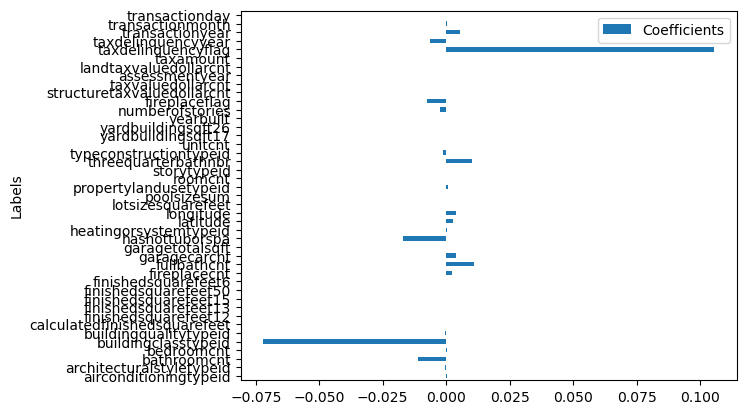

In [40]:
ax = coef_df.plot.barh(x='Labels', y='Coefficients', rot=0)

Most of them are closer to 0. Let's remove the unsignificant variables

In [41]:
coef_df.Labels[(coef_df['Coefficients'] >= 0.005) | (coef_df['Coefficients'] <= -0.005)].to_list()

['bathroomcnt',
 'buildingclasstypeid',
 'fullbathcnt',
 'hashottuborspa',
 'threequarterbathnbr',
 'fireplaceflag',
 'taxdelinquencyflag',
 'taxdelinquencyyear',
 'transactionyear']

In [42]:
closer_to_zero_list = coef_df.Labels[(coef_df['Coefficients'] >= -0.005) & (coef_df['Coefficients'] <= 0.005)].to_list()
print(closer_to_zero_list)

['airconditioningtypeid', 'architecturalstyletypeid', 'bedroomcnt', 'buildingqualitytypeid', 'calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'finishedsquarefeet13', 'finishedsquarefeet15', 'finishedsquarefeet50', 'finishedsquarefeet6', 'fireplacecnt', 'garagecarcnt', 'garagetotalsqft', 'heatingorsystemtypeid', 'latitude', 'longitude', 'lotsizesquarefeet', 'poolsizesum', 'propertylandusetypeid', 'roomcnt', 'storytypeid', 'typeconstructiontypeid', 'unitcnt', 'yardbuildingsqft17', 'yardbuildingsqft26', 'yearbuilt', 'numberofstories', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'assessmentyear', 'landtaxvaluedollarcnt', 'taxamount', 'transactionmonth', 'transactionday']


In [43]:
x_train

,airconditioningtypeid,architecturalstyletypeid,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,...,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,transactionyear,transactionmonth,transactionday
73362,1,28,3.0,2.0,6,4.0,930.0,930.0,1440.0,2100.0,...,138580.0,355085.0,2015.0,216505.0,4390.07,0,0.0,2016,3,2
72103,14,28,2.0,4.0,6,6.0,1827.0,1827.0,1440.0,2100.0,...,191845.0,334505.0,2016.0,142660.0,4137.83,0,0.0,2016,6,3
267779,14,28,1.0,1.0,6,7.0,702.0,702.0,1440.0,2100.0,...,62125.0,217571.0,2016.0,155446.0,2709.32,0,0.0,2017,1,30
150648,1,28,3.0,3.0,6,4.0,1429.0,1429.0,1440.0,2100.0,...,150493.0,188115.0,2015.0,37622.0,2427.39,0,0.0,2017,5,9
9452,14,28,1.0,2.0,6,7.0,806.0,806.0,1440.0,2100.0,...,20580.0,52581.0,2015.0,32001.0,891.44,0,0.0,2016,6,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117583,14,28,1.0,1.0,6,5.0,840.0,840.0,1440.0,2100.0,...,72680.0,210083.0,2016.0,137403.0,3173.45,0,0.0,2016,8,9
73349,1,28,3.0,4.0,6,7.0,2609.0,2609.0,1440.0,2100.0,...,149481.0,199410.0,2016.0,49929.0,3399.17,0,0.0,2017,7,14
312205,1,28,4.0,4.0,6,7.0,3260.0,3260.0,1440.0,2100.0,...,545203.0,883227.0,2016.0,338024.0,13483.05,0,0.0,2016,10,18
267340,1,28,2.0,4.0,6,4.0,1587.0,1587.0,1440.0,2100.0,...,147489.0,345773.0,2015.0,198284.0,4449.85,0,0.0,2017,3,28


In [44]:
x_train.drop(closer_to_zero_list, axis=1, inplace=True)
x_test.drop(closer_to_zero_list, axis=1, inplace=True)

In [45]:
scaler = preprocessing.StandardScaler().fit(x_train)
scaler

StandardScaler()

In [46]:
X_train_scaler = scaler.transform(x_train)
X_train_scaler

array([[ 0.70944795,  0.01364656,  0.78732427, ..., -0.17032061,
        -0.16760925, -0.92632254],
       [-0.29211084,  0.01364656, -0.2554772 , ..., -0.17032061,
        -0.16760925, -0.92632254],
       [-1.29366962,  0.01364656, -1.29827866, ..., -0.17032061,
        -0.16760925,  1.07953759],
       ...,
       [ 1.71100673,  0.01364656,  1.83012574, ..., -0.17032061,
        -0.16760925, -0.92632254],
       [-0.29211084,  0.01364656, -0.2554772 , ..., -0.17032061,
        -0.16760925,  1.07953759],
       [-0.29211084,  0.01364656, -0.2554772 , ..., -0.17032061,
        -0.16760925, -0.92632254]])

In [60]:
X_test_scaler = scaler.transform(x_test)
X_test_scaler

array([[-0.29211084,  0.01364656, -0.2554772 , ..., -0.17032061,
        -0.16760925, -0.92632254],
       [-1.29366962,  0.01364656, -1.29827866, ..., -0.17032061,
        -0.16760925, -0.92632254],
       [ 1.71100673,  0.01364656,  1.83012574, ..., -0.17032061,
        -0.16760925, -0.92632254],
       ...,
       [-0.29211084,  0.01364656, -0.2554772 , ..., -0.17032061,
        -0.16760925,  1.07953759],
       [-1.29366962,  0.01364656, -1.29827866, ...,  5.87127999,
         4.56284654, -0.92632254],
       [ 0.70944795,  0.01364656,  0.78732427, ..., -0.17032061,
        -0.16760925,  1.07953759]])

### Creating Linear SVM

In [94]:
svr_model = svm.SVR(kernel='linear')
svr_model.fit(X_train_scaler, y_train)

SVR(kernel='linear')

In [98]:
svr_model.score(X_train_scaler, y_train)

0.0013198314936464506

In [99]:
svr_model.score(X_test_scaler, y_test)

0.0006656225861348952

### Polynomial

In [100]:
svr_poly_model = svm.SVR(kernel='poly')
svr_poly_model.fit(X_train_scaler, y_train)

### RBF

In [57]:
svr_poly_model = svm.SVR(kernel='rbf')
svr_poly_model.fit(X_train_scaler, y_train)

SVR()

In [58]:
svr_poly_model.score(X_train_scaler, y_train)

0.0025239598736574997

In [61]:
svr_poly_model.score(X_test_scaler, y_test)

0.0012913085741375063

### Decision Tree Regression

In [54]:
dtr_model = DecisionTreeRegressor(max_depth=3)
dtr_model.fit(x_train, y_train)

DecisionTreeRegressor(max_depth=3)

In [55]:
dtr_model.score(x_train,y_train)

0.002052148810235299

In [56]:
dtr_model.score(x_test, y_test)

0.0007034384138500105